# BII project land use and intensity
This notebook contains the code for extracting, pre-processing, and applying the expert decsion tree and computing the intensity values of six categories of land use at a 1x1 km spatial resolution. 

Output: A shapefile with a point for every 1x1 km cell within a country.

### High-level steps
1. sub saharan african countries are identified (filtered)
2. A grid is created for the country of interest
3. All variables (Refer to list of variables.docx) required are extracted from Google Earth Engine at the aggregated 1km scale
4. Datasets are combined and pre-processed. Includes, filling in missing data, scaling data and correcting data types.
5. The expert decision tree is applied that outputs a land use for every point
6. Data is scaled and the intensity scores are computed

## Setup

In [1]:
import os
from datetime import datetime

import ee
# ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
import geemap, eerepr
from geemap import ee_to_geopandas
from tqdm.auto import tqdm
from geeml.utils import createGrid, getCountry, eeprint
from geeml.extract import extractor

from osgeo import gdal

In [2]:
# get sub-saharan countries
# https://code.earthengine.google.com/443ea31edb2f25f58a3346e7dc8c1064
countries = ee.FeatureCollection("USDOS/LSIB/2017")
c2 = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

africa = c2.filter(ee.Filter.eq('wld_rgn', 'Africa'))
sub = countries.filterBounds(africa).aggregate_array('COUNTRY_NA')\
.removeAll(['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Mayotte (Fr)', 'Spain [Canary Is]', 'Spain [Plazas de Soberania]', 'Portugal [Madeira Is]'])

sub_africa = countries.filter(ee.Filter.inList('COUNTRY_NA', sub))

In [3]:
country_list = sub_africa.aggregate_array('COUNTRY_NA').getInfo()

dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"

config = {}
for country in country_list:
    csavepath = f"{dd}/{country}"
    caoi = sub_africa.filter(ee.Filter.eq('COUNTRY_NA', country))
    config[country] = {'dd':csavepath,
                       'aoi':caoi}
print(config.keys())

dict_keys(['Benin', 'Niger', 'Nigeria', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia, The', 'Mozambique', 'Namibia', 'Gaza Strip (disp)', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Sierra Leone', 'Koualou (disp)', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Rwanda', 'Sao Tome & Principe', 'Senegal', 'Somalia', 'South Sudan', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Uganda', 'Western Sahara (disp)', 'Zambia', 'Zimbabwe', 'Israel', 'Abyei (disp)', 'Angola', 'Botswana', 'Comoros', 'Congo, Dem Rep of the', 'Congo, Rep of the', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', "Cote d'Ivoire", 'Central African Rep', 'Chad', 'South Africa'])


In [70]:
country = 'South Africa'

# Get current date- used for saving files
date = datetime.today().strftime('%d%m%Y')

aoi = config.get(country).get('aoi')

# Set path for saving data
dd = config.get(country).get('dd')
if not os.path.exists(dd):
    os.makedirs(dd)
    os.chdir(dd)
else:
    os.chdir(dd)
    
print(os.getcwd())

C:\Users\coach\myfiles\miscellenous\hayley\outputs\South Africa


In [71]:
# Sanity check that the correct country is selected
Map = geemap.Map()
Map.centerObject(aoi, 3)
Map.addLayer(aoi)
Map

Map(center=[-28.97574975972159, 25.201998135703736], controls=(WidgetControl(options=['position', 'transparent…

## Data extraction

In [72]:
# Define projection
wkt = '\
PROJCS["Africa_Albers_Equal_Area_Conic",\
    GEOGCS["GCS_WGS_1984",\
    DATUM["WGS_1984",\
    SPHEROID["WGS_1984",6378137,298.257223563]],\
    PRIMEM["Greenwich",0],\
    UNIT["Degree",0.017453292519943295]],\
    PROJECTION["Albers_Conic_Equal_Area"],\
    PARAMETER["False_Easting",0],\
    PARAMETER["False_Northing",0],\
    PARAMETER["longitude_of_center",25],\
    PARAMETER["Standard_Parallel_1",20],\
    PARAMETER["Standard_Parallel_2",-23],\
    PARAMETER["latitude_of_center",0],\
    UNIT["Meter",1],\
    AUTHORITY["EPSG","102022"]]'

# ALbers equal area for africa
epsg_102022 = ee.Projection(wkt)

grid1km, _ = createGrid(1000, aoi, crs = epsg_102022)
grid8km, _ = createGrid(8000, aoi, crs = epsg_102022)

In [73]:
# Urban cover (10m>>1km) 2019
area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019").filterBounds(aoi)\
.mosaic().eq(255).unmask(0)
urbanAreaImage = area.multiply(urban_cover).rename('areakm2_urban')

# Crop cover (30 m)
crop_cover = ee.ImageCollection("users/potapovpeter/Global_cropland_2019").filterBounds(aoi).mosaic()
cropAreaImage = area.multiply(crop_cover).rename('areakm2_cropCover')

# Protected area
prot_areas = ee.FeatureCollection("projects/ee-geethensingh/assets/WDPA_Africa_strict").filterBounds(aoi)
protectedAreaImage = area.clipToCollection(prot_areas).unmask(0).rename('areakm2_protArea')    

# Plantation and tree crop
result = ee.ImageCollection("users/liuzhujun/SDPT_NEW").mosaic()
plantag = ee.Image("users/duzhenrong/SDPT/sdpt_plantag")
china_plantyear = ee.ImageCollection("users/liuzhujun/SDPT_China").mosaic().rename('plantyear')
DescalesOP = ee.ImageCollection("users/liuzhujun/Descales").mosaic()
op = DescalesOP.updateMask(DescalesOP.gt(1980)).rename('plantyear')
sdpt_name = ee.Image("users/duzhenrong/SDPT/sdpt_name")

china_plantyear=china_plantyear.updateMask(china_plantyear.gt(1980))
result=result.rename('plantyear').updateMask((sdpt_name.lt(120).And(sdpt_name.gt(0))).Or(sdpt_name.gt(129))).toInt32()

plantationForest=ee.ImageCollection([result.updateMask(plantag.eq(1)),china_plantyear]).mosaic().gt(0).unmask(0) 
plantationAreaImage = area.updateMask(plantationForest).rename('areakm2_plantation')
treeCrop=result.multiply(plantag.eq(2))
treeCrop =ee.ImageCollection([treeCrop,op]).mosaic().gt(0)  
treeCropAreaImage = area.multiply(treeCrop).rename('areakm2_treeCrop')

#Soil nutrients
Soil_Lownutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Low'))
Soil_Mednutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Medium'))
Soil_Highnutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'High'))

soilLowNutrientAreaImage = area.clipToCollection(Soil_Lownutrient).unmask(0).rename('areakm2_slowNutrArea')
soilMedNutrientAreaImage = area.clipToCollection(Soil_Mednutrient).unmask(0).rename('areakm2_sMedNutriArea')
soilHighNutrientAreaImage = area.clipToCollection(Soil_Highnutrient).unmask(0).rename('areakm2_sHighNutriArea')

# Population Density
popDensity = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density")\
.select('unwpp-adjusted_population_density').filterBounds(aoi).mosaic().rename('popDensity').unmask(0)
                                       
# Grazing Intensity
area = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/GI_8_Areakm').unmask(0)
cattleDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Ct_2010_Da').divide(area).rename('cattleDensity').unmask(0)
sheepDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Sh_2010_Da').divide(area).rename('sheepDensity').unmask(0)
goatDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Gt_2010_Da').divide(area).rename('goatDensity').unmask(0)

# Precipitation
years = list(range(1991,2021))
precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(aoi)  
precipitation = ee.Image(ee.ImageCollection(ee.List(years).map(lambda year: precipitation\
.filterDate(ee.Number(year).format(), ee.Number(year).add(1).format()).sum())).mean().rename('mm_precipitation')).unmask(0)

# Nitrogen input
proj = ee.Projection('EPSG:4326').scale(0.25,0.25)
grid = aoi.geometry().coveringGrid(proj)

nInput = ee.FeatureCollection("projects/ee-geethensingh/assets/Nfur_15arcmins_transformed").filterBounds(aoi)\
.map(lambda x: x.set("Nfer_type",ee.Algorithms.ObjectType(x.get("Nfer_kgha_"))))
nInputStr = nInput.filter(ee.Filter.eq('Nfer_type', 'String')).map(lambda x: x.set("Nfer_kgha_",ee.Number.parse(x.get("Nfer_kgha_")).toFloat()))
nInputNumber = nInput.filter(ee.Filter.neq('Nfer_type', 'String')).map(lambda x: x.set("Nfer_kgha_",ee.Number(x.get("Nfer_kgha_")).toFloat()))

nInput = nInputStr.merge(nInputNumber)

def pointToGrid(ft):
    feat = ee.Feature(ft);
    first = nInput.filterBounds(feat.geometry()).aggregate_first('Nfer_kgha_');
    return feat.set('Nfer_kgha_', first);

nInput = grid.filterBounds(nInput).map(pointToGrid)\
.reduceToImage(**{'properties': ee.List(["Nfer_kgha_"]), 'reducer': ee.Reducer.first()})\
.rename('Nfer_kgha').unmask(0)

# FieldSize
fieldSize = ee_to_geopandas(ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes")\
                            .filterBounds(aoi)\
                            .filter(ee.Filter.neq('field_size', 'NA'))\
                            .map(lambda x: x.set("fieldSize",ee.Number.parse(x.get("field_size")))\
                            ).select(['fieldSize', 'geometry'])).set_crs('EPSG:4326').to_crs(wkt)

In [ ]:
# # Extract data
sumCovariates = urbanAreaImage.addBands([cropAreaImage, protectedAreaImage, soilLowNutrientAreaImage,\
                                    soilMedNutrientAreaImage, soilHighNutrientAreaImage,\
                                    plantationAreaImage, treeCropAreaImage])
# extract 30m datasets for 1km grid using sum reducer
extractor(sumCovariates, aoi.geometry(), scale = 30, dd = dd, target = grid1km, crs = epsg_102022, num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.sum(), gridSize = 100000, batchSize = 5000, filename = 'sum_1km.csv')

coords = ee.Image.pixelCoordinates(epsg_102022)

# extract field size and unique id's at 1km scale using 1km grid using first reducer
extractor(coords, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = epsg_102022, num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.first(), gridSize = 100000, batchSize = 5000, filename = 'coords_1km.csv')

# Extract precipitation and nitrogen Input
meanCovariates = precipitation.addBands([nInput, popDensity,\
                                        sheepDensity, goatDensity,cattleDensity])

extractor(meanCovariates, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = epsg_102022, num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.mean(), gridSize = 100000, batchSize = 5000, filename = 'mean_1km.csv')


sum_1km.csv: |                                                                         | [  0.0%] in 00:00 (et…

## Prepare data
## 1km

In [74]:
# For grid cells with crop_cover and no data, assign field size of nearest cell.
import math
import os

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tqdm.auto import tqdm

from scipy.spatial import cKDTree
from shapely.geometry import Point

In [75]:
def ckdnearest(gdA, gdB, k=1):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=k)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [76]:
# #Field Size data
df = pd.read_csv(r"coords_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
df.columns = ['x', 'y', 'gid']

In [77]:
df1 = pd.read_csv(r"sum_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
df1.columns = ['areakm2_urban','areakm2_cropCover', 'areakm2_protArea',
       'areakm2_slowNutrArea', 'areakm2_sMedNutriArea',
       'areakm2_sHighNutriArea', 'areakm2_plantation', 'areakm2_treeCrop', 'gid']

In [78]:
# Mean covariate data
dfmean = pd.read_csv(r"mean_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
dfmean.columns = ['mean_precip','Nfer_kgha', 'popDensity', 'sheepDensity', 'goatDensity', 'cattleDensity', 'gid']
dfmean= dfmean[dfmean['gid']!= '245,-2948']

In [79]:
# Merge datasets into single datset based on matching GIS column
dfJoin = pd.merge(df1, dfmean, on= 'gid')
dfAll = pd.merge(dfJoin, df, on= 'gid').drop_duplicates().reset_index(drop=True)

In [80]:
# Fill in missing mean precipitation data
# by copying attribute of closest point
missing = dfAll.mean_precip.isna().sum()
print('The number of missing mean_precip values:', missing)
if missing>0:
    # Blocks with mean-precip data
    sdf2 = dfAll.loc[dfAll['mean_precip'].notna(), ['mean_precip', 'x', 'y']]
    gdf2 =  gpd.GeoDataFrame(sdf2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf2.x, sdf2.y))

    # All columns without join-attributes(s) column
    sdf1 = dfAll.loc[dfAll['mean_precip'].isna(), ['gid','x', 'y']]
    gdf1 =  gpd.GeoDataFrame(sdf1.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf1.x, sdf1.y))

    joinNearest1 = ckdnearest(gdf1, gdf2)

    result1 = pd.DataFrame(joinNearest1)[['gid', 'mean_precip']]
    result1.columns = ['gid', 'mean_precip2']

    dfAll = pd.merge(dfAll, result1, how = 'outer',on = 'gid').drop_duplicates()
    dfAll['mean_precip'].fillna(dfAll['mean_precip2'], inplace = True)
    dfAll.drop('mean_precip2', axis=1, inplace=True)

The number of missing mean_precip values: 0


In [81]:
dfF = dfAll[dfAll['areakm2_treeCrop']!= '2726,-3471']

# Format data types
dfF.loc[:,'areakm2_treeCrop'] = dfF.loc[:,'areakm2_treeCrop'].astype('float64')
dfF.loc[:,'gid'] = dfF.loc[:,'gid'].astype('string')
dfF.loc[:,'Nfer_kgha'] = dfF.loc[:,'Nfer_kgha'].astype('float64')
dfF.loc[:,'mean_precip'] = dfF.loc[:,'mean_precip'].astype('float32')

In [82]:
# Fill in missing Nutrient data
# Copy attribute of closest point
df = dfF
df['maxN'] = df[['areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea']].max(axis=1)

missing = df[df.maxN==0].shape[0]
print('The number of missing soil nutrient values:', missing)
if missing>0:
    # Blocks with Nutrient areas
    sdf2 = df.loc[df['maxN']>0, ['areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea', 'x', 'y']]
    gdf2 =  gpd.GeoDataFrame(sdf2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf2.x, sdf2.y))

    # All columns without join-attributes(s) column
    sdf1 = df[['gid', 'x', 'y']]
    gdf1 =  gpd.GeoDataFrame(sdf1.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(sdf1.x, sdf1.y))

    joinNearest1 = ckdnearest(gdf1, gdf2)

    result1 = pd.DataFrame(joinNearest1)[['gid', 'areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea']]
    result1.columns = ['gid', 'areakm2_slowNutrArea2','areakm2_sMedNutriArea2', 'areakm2_sHighNutriArea2']

    finaldf = pd.merge(df, result1, how = 'outer',on = 'gid')

The number of missing soil nutrient values: 8804


In [83]:
# Add small value to zero precip
finaldf.loc[finaldf.mean_precip==0, 'mean_precip'] = 0.1
# Round of to the nearest 400
max_round = math.ceil(max(finaldf['mean_precip']) / 400) * 400
cut_bins = list(range(0, max_round+1, 400))
# discretize precipitation into categories 
cut_labels = [str(item) for item in range(0, len(cut_bins)-1)]
finaldf["precipDiscrete"] = pd.cut(x = finaldf["mean_precip"].astype(float), bins= cut_bins, labels = cut_labels)
print(finaldf.precipDiscrete.value_counts())

# Identify the max nutrient area
finaldf['maxNutr'] = finaldf[['areakm2_slowNutrArea2','areakm2_sMedNutriArea2', 'areakm2_sHighNutriArea2']].idxmax(axis=1)

# Get unique category based on precip bucket and max nutrient category
finaldf['combination_LS_intensity'] = finaldf[['precipDiscrete','maxNutr']].agg(tuple, axis=1)
finaldf['lsIntensityCat'] = finaldf['combination_LS_intensity'].factorize()[0]

1    569218
0    564672
2     89023
3      1581
Name: precipDiscrete, dtype: int64


In [84]:
# Get unique combinations of precipitation and maxNutrient categories
combinations = list(set(finaldf['lsIntensityCat']))
print("Livestock Intensity categories (based on unique combinations of discretised precipitation and max nutrient category):",combinations)

# Compute the sum of sheep, goat and cattle density
finaldf['lsSum'] = finaldf[['sheepDensity', 'goatDensity', 'cattleDensity']].sum(axis=1)

# Scale data
finaldf['scaled_livestockIntensity']= 0
for combination in tqdm(combinations):
    qq99 = finaldf.loc[(finaldf['lsIntensityCat'] == combination),'lsSum'].quantile(0.99)
    print(f'The 99th percentile of summed livestock density for combination {combination} is: {qq99}')
    # if there are rows
    if finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity'].shape[0]>0:
        # apply min max scaling to all data less than 99th quantile per unique combination.
        scaler = MinMaxScaler()
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity']\
        = scaler.fit_transform(pd.DataFrame(finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99)\
                                                    , 'lsSum']))
    else: 
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity'] =\
        finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']<qq99), 'scaled_livestockIntensity']
    # for data greater than 99th percentile per category, equal to max value 1
    finaldf.loc[(finaldf['lsIntensityCat'] == combination)&(finaldf['lsSum']>=qq99), 'scaled_livestockIntensity'] = 1

Livestock Intensity categories (based on unique combinations of discretised precipitation and max nutrient category): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


  0%|          | 0/10 [00:00<?, ?it/s]

The 99th percentile of summed livestock density for combination 0 is: 68.50616715916733
The 99th percentile of summed livestock density for combination 1 is: 107.79063468785598
The 99th percentile of summed livestock density for combination 2 is: 80.87864234479447
The 99th percentile of summed livestock density for combination 3 is: 62.895745183213094
The 99th percentile of summed livestock density for combination 4 is: 117.32404186970409
The 99th percentile of summed livestock density for combination 5 is: 89.86606409744698
The 99th percentile of summed livestock density for combination 6 is: 53.86634956167717
The 99th percentile of summed livestock density for combination 7 is: 33.217511940317536
The 99th percentile of summed livestock density for combination 8 is: 52.06253627836344
The 99th percentile of summed livestock density for combination 9 is: 32.500158993272485


In [85]:
# Export data
outfile = f'{country}_POC_{date}.feather'
finaldf.drop_duplicates(subset = ['x', 'y']).reset_index(drop=True).to_feather(outfile)

## Decision tree

In [86]:
def ckdnearest_fsz(gdA, gdB, k=5):
    """
    For rows with no field size data, identify the 5-closest points -> select the most common fieldSize.
    If there are 2 most field sizes, drop the furthest point and redetermine most common field Size.
    
    Args:
        gdA (pandas DataFrame): contains rows with missing data in column named 'fieldSize'
        gdB (pandas DataFrame): contains rows with no missing data in column named 'fieldSize'
        k (int): Determines the number of closest points considered
    
    Returns:
        gdA (pandas dataframe) with filled in missing data at column named 'fieldSize2'.
        If the 5 points are each different fieldsizes, this function will not work.
    """
    # get 5-closest pts
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=k)
    
    gdA['fieldSize2'] = np.nan
    for row in tqdm(range(idx.shape[0])):
        # get 5 rows
        data = gdB.iloc[idx[row],:]
        # get most common fieldsize value
        if data['fieldSize'].value_counts().mode().shape[0]==1:
            most_common = data['fieldSize'].value_counts().idxmax()
            gdA.at[row, 'fieldSize2'] = most_common
        # if 2 or more values are returned, drop point with greatest distance
        else:
            fts = pd.DataFrame(np.column_stack([dist[row], idx[row]]), columns=['dist', 'idx'])
            # drop point with greatest distance
            idx_i = list(fts.loc[fts['dist']<fts['dist'].max(), 'idx'])
            data = gdB.iloc[idx_i,:]
            # get most common value
            most_common = data['fieldSize'].value_counts().idxmax()
            gdA.at[row, 'fieldSize2'] = most_common
    return gdA

In [87]:
infile = f'{country}_POC_{date}.feather'
df = pd.read_feather(infile).dropna().reset_index(drop=True)

In [88]:
#1= Urban
#2= Timber plantations
#3= Tree Croplands
#4= CropLands
#5= Protected areas
#6= Rangelands/Near-natural lands

def ExpertDT(df):

    #6= Rangelands/Near-natural lands
    df['Land_Use'] = 6

    #5= Protected areas
    df.loc[df['areakm2_protArea']>0.2, 'Land_Use'] = 5

    #4= CropLands
    df.loc[df['areakm2_cropCover']>0.2, 'Land_Use'] = 4

    #3= Tree Croplands
    df.loc[df['areakm2_treeCrop']>0.2, 'Land_Use'] = 3

    #2= Timber plantations
    df.loc[df['areakm2_plantation']>0.2, 'Land_Use'] = 2

    #1= Urban
    df.loc[(df['areakm2_urban']>0.2)|
           (df['popDensity']>1000) , 'Land_Use'] = 1
    return df
    
result = ExpertDT(df)
print('The number of cells per landcover category')
result['Land_Use'].value_counts()

The number of cells per landcover category


6    972326
4    117572
5     86370
2     25632
1     17032
3      5562
Name: Land_Use, dtype: int64

In [89]:
# get rows with fieldsize, cropcover or treeCrop data-used for joining
val_list = [3502, 3503, 3504, 3505, 3506]
gdf1 = fieldSize.loc[fieldSize['fieldSize'].isin(val_list), ].reset_index(drop=True) #select all rows with valid field size data

# select landcover 3 and 4 (tree crop and crop)
dfs2 = result.loc[(result['Land_Use']==3)|(result['Land_Use']==4),['x', 'y', 'gid']].reset_index(drop=True)
# Convert to gdf
gdf2 = gpd.GeoDataFrame(dfs2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(dfs2.x, dfs2.y)).set_crs(wkt)

print(f'fill in {gdf2.shape[0]} missing field size values')

fill in 123134 missing field size values


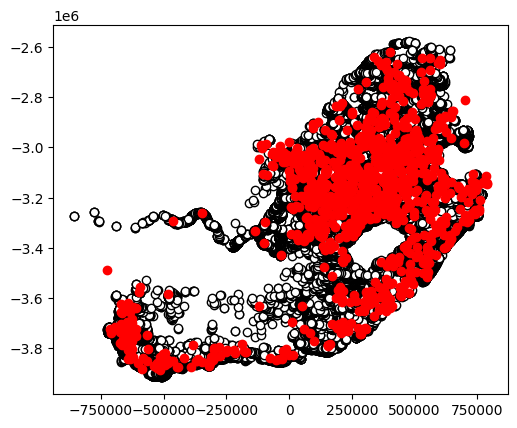

In [90]:
# Check if datasets overlap (same projection
ax = gdf2.to_crs(wkt).plot(color='white', edgecolor='black')

# plot ``GeoDataFrame``.
gdf1.to_crs(wkt).plot(ax=ax, color='red')
plt.show()

In [91]:
joinNearest = ckdnearest_fsz(gdf2, gdf1, k=5)
df1 = pd.DataFrame(joinNearest[['gid', 'fieldSize2']])

finaldf = pd.merge(result, df1, how= 'outer',on = 'gid')
finaldf['fieldSize'] = finaldf['fieldSize2'].fillna(-1).astype('int')

dfF = finaldf.drop('fieldSize2', axis=1).reset_index(drop=True)

  0%|          | 0/123134 [00:00<?, ?it/s]

In [92]:
# Add scaled fieldSize
dfF['scaled_fieldSize'] = -1
dfF.loc[dfF['fieldSize'] == 3502, 'scaled_fieldSize'] = 1.0
dfF.loc[dfF['fieldSize'] == 3503, 'scaled_fieldSize'] = 0.75
dfF.loc[dfF['fieldSize'] == 3504, 'scaled_fieldSize'] = 0.50
dfF.loc[dfF['fieldSize'] == 3505, 'scaled_fieldSize'] = 0.25
dfF.loc[dfF['fieldSize'] == 3506, 'scaled_fieldSize'] = 0

In [93]:
# Scale variables
colnames = ['Nfer_kgha', 'popDensity']

result = dfF
for col in colnames:
    # create scaled variable
    result['scaled_'+col] = 0
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==3), col].shape[0]>0):
#         For tree croplands
        # get 99th percentile is equal to 0.99 quantile
        qq99 = result.loc[(result['Land_Use']==3), col].quantile(0.99)
        print(f"{col} for Tree Croplands: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==3), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==3), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==3), 'scaled_' + col] = 1
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==4), col].shape[0]>0):
#         for croplands
        # get 99th percentile
        qq99 = result.loc[(result['Land_Use']==4), col].quantile(0.99)
        print(f"{col} for CropCover: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==4), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==4), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==4), 'scaled_' + col] = 1
    if (col=='Nfer_kgha')&(result.loc[(result['Land_Use']==6), col].shape[0]>0):
#         for rangelands
        # get 99th percentile
        qq99 = result.loc[(result['Land_Use']==6), col].quantile(0.99)
        print(f"{col} for Rangeland: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==6), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==6), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==6), 'scaled_' + col] = 1
        
    if col=='popDensity':
        # get 99th percentile
        qq99 = result.loc[result['Land_Use']==1, col].quantile(0.99)
        print(f"{col} for urban areas: {qq99}")
        # apply min max scaling to all data less than 99th quantile.
        scaler = MinMaxScaler()
        result.loc[(result[col]<qq99)&(result['Land_Use']==1), 'scaled_'+ col] =\
        scaler.fit_transform(pd.DataFrame(result.loc[(result[col]<qq99)&(result['Land_Use']==1), col]))
        # for data greater than 99th percentile, equal to max value 1
        result.loc[(result[col]>=qq99)&(result['Land_Use']==1), 'scaled_' + col] = 1

Nfer_kgha for Tree Croplands: 18.512
Nfer_kgha for CropCover: 31.28
Nfer_kgha for Rangeland: 19.7136
popDensity for urban areas: 15616.674990234374


## Intensity

In [94]:
result['intensity'] = -1
result['scaled_intensity'] = -1

#1= Urban
# check if there are urban land use pixels
if result.loc[(result['Land_Use']==1), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 1 (urban area)')
#     scale urban area between 0 and 1 (from 0.2 to 1)
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==1), 'scaled_areakm2_urban'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==1)\
                                                                                                             , 'areakm2_urban']))
#     assign intensity scores based on an equal weighting of scaled popDensity and scaled urban area
    result.loc[(result['Land_Use']==1), 'intensity'] = (result['scaled_areakm2_urban']+\
                                                        result['scaled_popDensity'])/2
#     scale raw intensity values between 0 and 1 within a land use
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']== 1), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==1)\
                                                                                                                   , 'intensity']))

#3= Tree Croplands
if result.loc[(result['Land_Use']==3), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 3 (tree_crop)')
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==3), 'scaled_areakm2_treeCrop'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==3)\
                                                                                                                  , 'areakm2_treeCrop']))
    result.loc[(result['Land_Use']==3), 'intensity'] = (result['scaled_areakm2_treeCrop']+\
                                                        result['scaled_fieldSize']+\
                                                        result['scaled_Nfer_kgha']\
                                                       )/3
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==3), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==3)\
                                                                                                                   , 'intensity']))

#4 = Croplands
if result.loc[(result['Land_Use']==4), 'intensity'].shape[0]>0:
    print('Computing Intensity for Land Use 4 (crop cover)')
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==4), 'scaled_areakm2_cropCover'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==4)\
                                                                                                                   , 'areakm2_cropCover']))
    result.loc[(result['Land_Use']==4), 'intensity'] = (result['scaled_areakm2_cropCover']+\
                                                        result['scaled_fieldSize']+\
                                                        result['scaled_Nfer_kgha']\
                                                       )/3
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==4), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==4)\
                                                                                                                   , 'intensity']))

#6 = Rangelands/ Near-naturallands
print('Computing Intensity for Land Use 6 (Rangelands)')
if result.loc[(result['Land_Use']==6), 'intensity'].shape[0]>0:
    result.loc[(result['Land_Use']==6), 'intensity'] = (result['scaled_livestockIntensity']+\
                                                        result['scaled_Nfer_kgha'])/2
                                                                                                                   
    scaler = MinMaxScaler()
    result.loc[(result['Land_Use']==6), 'scaled_intensity'] = scaler.fit_transform(pd.DataFrame(result.loc[(result['Land_Use']==6)\
                                                                                                                   , 'intensity']))

    
# result = result.fillna(-1)

Computing Intensity for Land Use 1 (urban area)
Computing Intensity for Land Use 3 (tree_crop)
Computing Intensity for Land Use 4 (crop cover)
Computing Intensity for Land Use 6 (Rangelands)


In [95]:
gdf = gpd.GeoDataFrame(result.drop(['x', 'y','combination_LS_intensity', 'areakm2_slowNutrArea','areakm2_sMedNutriArea', 'areakm2_sHighNutriArea'], axis = 1),
                       geometry = gpd.points_from_xy(result.x, result.y), crs= wkt).to_crs(crs= 'EPSG:4326')

In [96]:
shp_cols = {'areakm2_urban':'km2_urban',
            'areakm2_cropCover':'km2_cropCov',
            'areakm2_protArea':'km2_protAr',
            'km2_plntn':'areakm2_plantation',
            'areakm2_treeCrop':'km2_trCrp',
            'gid':'gid',
            'mean_precip':'mean_precip',
            'Nfer_kgha':'mean_Nfer',
            'popDensity':'sum_popDen',
            'sheepDensity':'sum_shpDen',
            'goatDensity':'sum_gtDen',
            'cattleDensity':'sum_ctlDen',
            'maxN':'maxSNtrAr',
            'areakm2_slowNutrArea2':'km2_sLwNtr',
            'areakm2_sMedNutriArea2':'km2_sMdNtr',
            'areakm2_sHighNutriArea2':'km2_sHgNtr',
            'precipDiscrete':'precipDisc',
            'maxNutr':'maxSNtrCat',
            'lsIntensityCat':'LSIntenCat',
            'lsSum':'LSSum',
            'scaled_livestockIntensity':'LSIntenScd',
            'Land_Use':'Land_Use',
            'fieldSize':'fieldSize',
            'scaled_fieldSize':'fieldSzScd',
            'scaled_Nfer_kgha':'NferScd',
            'scaled_popDensity':'popDenScd',
            'intensity':'Intensity',
            'scaled_intensity':'SdItensity',
            'scaled_areakm2_urban':'km2_ubn_sd',
            'scaled_areakm2_treeCrop':'km2_trCrpS',
            'scaled_areakm2_cropCover':'km2_crpCvS',
            'geometry':'geometry'}

In [97]:
gdf.rename(columns=shp_cols, inplace = True)
gdf.columns

Index(['km2_urban', 'km2_cropCov', 'km2_protAr', 'areakm2_plantation',
       'km2_trCrp', 'gid', 'mean_precip', 'mean_Nfer', 'sum_popDen',
       'sum_shpDen', 'sum_gtDen', 'sum_ctlDen', 'maxSNtrAr', 'km2_sLwNtr',
       'km2_sMdNtr', 'km2_sHgNtr', 'precipDisc', 'maxSNtrCat', 'LSIntenCat',
       'LSSum', 'LSIntenScd', 'Land_Use', 'fieldSize', 'fieldSzScd', 'NferScd',
       'popDenScd', 'Intensity', 'SdItensity', 'km2_ubn_sd', 'km2_trCrpS',
       'km2_crpCvS', 'geometry'],
      dtype='object')

In [98]:
gdf.loc[:,'precipDisc'] = gdf.loc[:,'precipDisc'].astype('int')
gdf.loc[:,'maxSNtrCat'] = gdf.loc[:,'maxSNtrCat'].astype('string')

In [67]:
print(os.getcwd())
outfile = f"{country}_1km_{date}.shp"
gdf.to_file(outfile)

C:\Users\coach\myfiles\miscellenous\hayley\outputs\Nigeria


In [99]:
input_vector = f"{country}_1km_{date}.shp"
output_raster = f"{country}_1km_{date}.tif"
x_resolution = 0.01
y_resolution = 0.01
attribute_name1 = "Land_Use"
attribute_name2 = "SdItensity"
no_data_value = 0
data_type = gdal.GDT_Float32
format = "GTiff"
xmin, ymin, xmax, ymax = gdf.total_bounds

# Open the input vector
ds = gdal.OpenEx(input_vector)
layer = ds.GetLayer()

# Create the output raster
driver = gdal.GetDriverByName(format)
raster_ds = driver.Create(output_raster, int((xmax - xmin) / x_resolution),
                          int((ymax - ymin) / y_resolution), 2, data_type)
raster_ds.SetGeoTransform((xmin, x_resolution, 0, ymax, 0, -y_resolution))

gdal.RasterizeLayer(raster_ds, [1], layer, options=[f"ATTRIBUTE={attribute_name1}"])
gdal.RasterizeLayer(raster_ds, [2], layer, options=[f"ATTRIBUTE={attribute_name2}"])

band1 = raster_ds.GetRasterBand(1)
band1.SetNoDataValue(no_data_value)
band1.SetDescription("Land Use")

band2 = raster_ds.GetRasterBand(2)
band2.SetNoDataValue(no_data_value)
band2.SetDescription("Intensity (scaled)")

raster_ds = None  # Close the file

# wishlist
1. automate checks
2. given a country and a task or set of tasks, execute code.

t1. extract data  
t2. decision tree + intensity scores  
visulise options  
save options  
